### Spotipy (Spotify Web API Python wrapper) setup & quick tutorial

In [59]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import seaborn as sns

import logging

from sklearn.cluster import KMeans

In [25]:
### Set up API auth
cid = '8bdd55c606af499581a2f6fa6619b956' #client ID
secret = '687bddf834984225abd085ac6f0dfd41' #secret
user = 'gza59mo1lxjaokuzj5752p5m9'

scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(cid, secret, scope=scope, redirect_uri='http://localhost:8000'))

In [ ]:
# Get songs from playlist URI and user name
def get_songs_from_playlistURL(plURL, user, sp):
    track_ids = []
    track_names = []
    tracks = sp.user_playlist(user, plURL)['tracks']['items']

    for i in range(0, len(tracks)):
        track_ids.append(tracks[i]['track']['id'])
        track_names.append(tracks[i]['track']['name'])

    all_songs = pd.DataFrame({'id': track_ids, 'names': track_names})
    song_names = all_songs['names']
    return all_songs

In [48]:
# Get song feautures
def get_song_features(all_songs, sp):
    features_df = pd.DataFrame()
    for i in range(0, len(all_songs)):
        audio_features = sp.audio_features(all_songs.loc[i, 'id'])
        af = pd.DataFrame(audio_features)
        
        features_df = pd.concat([features_df, af])
    features_df.set_index('id', inplace = True)
    features_df.drop(['key', 'type', 'mode', 'uri', 'track_href', 'analysis_url', 'time_signature', 'duration_ms'], axis=1, inplace=True)
    return features_df

In [ ]:
# Print results
def print_crossval_param_scores(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
# ===== Drop unimportant features =====
features_df.drop(['key', 'mode', 'type', 'uri' , 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'tempo'], inplace = True, axis = 1)

### Idea: Clustering songs by their audio features

In [ ]:
### K-means
kmeans = KMeans(n_clusters = 4).fit(features_df)
features_df['kmeans_cluster'] = kmeans.labels_
features_df

In [ ]:
# Show clusters for all features
sns.pairplot(features_df, hue = 'cluster')

In [ ]:
# ===== a check for other clusters with clustering labels - we don't want them to interfere with our clustering calculations!!! =====
for i in ['kmeans_cluster', 'af_cluster', 'cluster']:
    if i in features_df.columns:
        features_df.drop(i, axis = 1, inplace = True)
print(features_df.columns)
cols = features_df.columns
#  Affinity Propagation
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(features_df)
features_df['af_cluster'] = af.labels_
features_df

In [ ]:
sns.pairplot(features_df, hue = 'af_cluster')

### z-transform + PCA followed by k-means clustering

In [ ]:
# z-transform (standardization)
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler().fit(features_df)
features_standardized = standard_scaler.fit_transform(features_df)
features_standardized = pd.DataFrame(features_standardized)
#features_standardized.columns = cols
features_standardized

In [ ]:
# Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 1).fit(features_standardized)
pca_dimred = pca.transform(features_standardized)

pca_dimred = pd.DataFrame(pca_dimred)
pca_dimred.columns = ['pc1', 'pc2']
#sns.scatterplot(x = pca_dimred[:, 0], 
#                y = pca_dimred[:, 1])

In [ ]:
# K-means on firstr 2 principal components of data
kmeans_pca = KMeans(n_clusters = 3).fit(pca_dimred)
pca_dimred['kmeans_pca_cluster'] = kmeans_pca.labels_

sns.scatterplot(x = pca_dimred['pc1'],
                y = pca_dimred['pc2'],
                hue = pca_dimred['kmeans_pca_cluster'])

In [ ]:
pca_dimred.set_index(song_names, inplace = True)
pca.dimred

## Idea: Classification
#### Make training dataset with some songs from playlist + random songs
#### Classes = 1 or 0, in playlist = 1 (like) / not in playlist = 0 (do not like)
#### Train binary classifier on this, and then test its accuracy on a dataset of the same kind
#### Also try binary clustering, using same dataset

In [ ]:
##### Construct training set

# Get spotify playlist of genre's user would NOT like
#i.e. Christian, Classical, and Rap 

# Get a Christian playlist
christian_rock_songs = get_songs_from_playlistURL('https://open.spotify.com/playlist/30wdzfOKmW7JmLPiQI0BGC?si=ddfbb1ce031b49ef',
                                                  'gza59mo1lxjaokuzj5752p5m9',
                                                 sp)
print(len(christian_rock_songs))
# Get a Classical playlist 
classical_songs = get_songs_from_playlistURL('https://open.spotify.com/playlist/27Zm1P410dPfedsdoO9fqm?si=483250c08cd64782',
                                            'gza59mo1lxjaokuzj5752p5m9',
                                            sp)
print(len(classical_songs))
# Get a Rap playlist 
rap_songs = get_songs_from_playlistURL('https://open.spotify.com/playlist/4riovLwMCrY3q0Cd4e0Sqp?si=42c183a75939403b',
                                      'gza59mo1lxjaokuzj5752p5m9',
                                      sp)
print(len(rap_songs))
# Combine all 
not_liked_songs = pd.concat([christian_rock_songs, classical_songs, rap_songs])
not_liked_songs.reset_index(inplace = True)
not_liked_songs

In [ ]:
##### Get all not-liked song features
not_liked_features = get_song_features(not_liked_songs, sp)

In [ ]:
# Drop unnecessary columns
not_liked_features.drop(['key', 'type', 'mode', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1, inplace = True)

In [ ]:
# get songs that user does like
liked_songs = get_songs_from_playlistURL('https://open.spotify.com/playlist/5G5zCN9WRAi8EQtabAjGHg?si=22288fe4f0de40dd',
                                         'gza59mo1lxjaokuzj5752p5m9',
                                         sp)
liked_song_features = get_song_features(liked_songs, sp)

In [46]:
# Drop unnecessary columns
#liked_song_features.drop(['key', 'type', 'mode', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1, inplace = True)

# make final df
liked_song_features['liked'] = 1
not_liked_features['liked'] = 0

song_features = pd.concat([liked_song_features, not_liked_features], axis = 0)

X = song_features.iloc[:,0:9]
y = song_features.iloc[:,10]

##### Split into train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
print(X)
print(y)

                        danceability  energy  loudness  speechiness   
id                                                                    
1y5V5qja332UyMeUurFhDS         0.551   0.882    -6.808       0.0454  \
5R0v2GLujsGk37QCkGdvMQ         0.554   0.815   -12.481       0.0409   
4W4wYHtsrgDiivRASVOINL         0.701   0.803    -6.786       0.0545   
7jIAttgQTpLDoNtykIQXjH         0.726   0.537    -8.896       0.1140   
1BtOAYgTkPnv1KRcLHqyxO         0.505   0.701   -12.031       0.0349   
...                              ...     ...       ...          ...   
4HbiCvH1R7mVOJ7KY7JQBD         0.660   0.775    -4.926       0.1720   
2BJSMvOGABRxokHKB0OI8i         0.673   0.649    -8.433       0.1960   
7zLYKWcXnYeHHWidalz7rj         0.699   0.558    -7.622       0.0603   
2DQ1ITjI0YoLFzuADN1ZBW         0.838   0.771    -3.791       0.2440   
4X5f3vT8MRuXF68pfjNte5         0.853   0.693    -6.870       0.2750   

                        acousticness  instrumentalness  liveness  valence   

# Clustering
#### As a performance metric we will use the F0.5 Score
#### Algorithms to try:
##### Linear: Logistic Regression, LDA, and Bayes Classifier
##### Nonlinear:  Decision Tree, KNN, SVM, Artificial Neural Networks (ANNs)

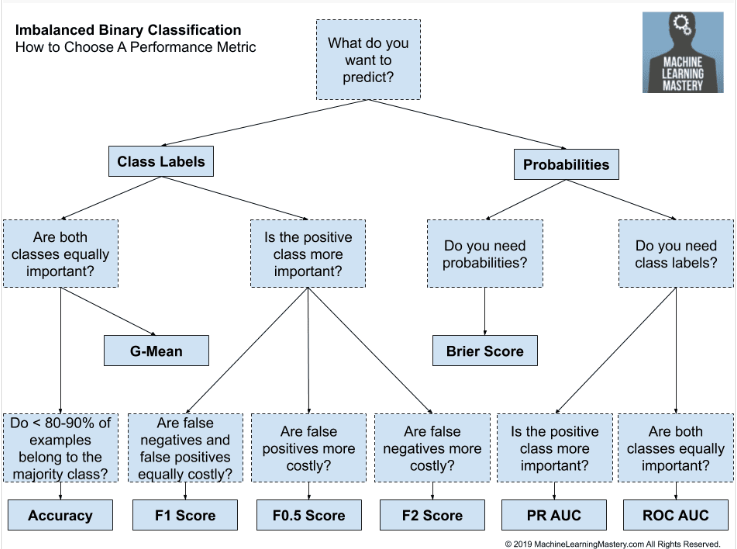)

In [ ]:
### Test a dumb classifier
# It will guess the majority class (0) for all instances
y_true = y
y_pred_dumb = [0] * 370

# See performance
dumb_classifier = pd.DataFrame({'actual': y_true, 'dumb_prediction': y_pred_dumb})
dumb_classifier['correct'] = np.where(dumb_classifier['actual'] == dumb_classifier['dumb_prediction'], True, False)
correct = dumb_classifier['correct'].value_counts()[0]
total = len(dumb_classifier)
correct/total
#0.811, when guessing majority class['key', 'type', 'mode', 'uri', 'track_href', 'analysis_url', 'time_signature']

In [ ]:
### Log['key', 'type', 'mode', 'uri', 'track_href', 'analysis_url', 'time_signature']istic Regression
from sklearn.linear_model import LogisticRegression
# Standardize (z-score) data with StandardScaler
from sklearn.preprocessing import StandardScaler
# Tune hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#Define model obj
lr = LogisticRegression()

# Standardize data
std_scaler = StandardScaler()
std_scaler.fit(X)
X = std_scaler.transform(X)

# Define parameter lists for tuning
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver = solvers,penalty = penalty,C = c_values)

# Stratified K fold
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = lr, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy', error_score=0)
grid_result = grid_search.fit(X, y)

print_crossval_param_scores(grid_result)
#0.918

In [ ]:
### Ridge Classifier
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier()
# Tuning hyperparameters:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
grid = dict(alpha=alpha)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
grid_search = GridSearchCV(estimator = rc, param_grid =['key', 'type', 'mode', 'uri', 'track_href', 'analysis_url', 'time_signature'] grid, n_jobs = -1, cv = cv, scoring = 'f1_micro', error_score=0)
grid_result = grid_search.fit(X, y)

print_crossval_param_scores(grid_result)
#0.9135

In [ ]:
### KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Tuning hyperparameters:
n_neighbors = range(1, 50)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = knn, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'f1_micro', error_score=0)
grid_result = grid_search.fit(X, y)

print_crossval_param_scores(grid_result)
#0.9297

In [ ]:
### SVM
from sklearn.svm import SVC # SVC support vectors classifier
svc = SVC()

# Tuning hyperparameters:
c = np.linspace(0.1,5,41)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = range(1,11)
gamma = ['scale','auto']
### there are more ...

grid = dict(C=c, kernel=kernel, degree=degree, gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = svc, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'f1_micro', error_score=0)
grid_result = grid_search.fit(X, y)

print_crossval_param_scores(grid_result)
#0.9288

In [23]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# Tuning hyperparameters:
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators, max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = rfc, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'f1_micro', error_score=0)
grid_result = grid_search.fit(X, y)

print_crossval_param_scores(grid_result)
#0.9405

Best: 0.940541 using {'max_features': 'log2', 'n_estimators': 1000}
0.916216 (0.032244) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.939640 (0.030960) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.938739 (0.034845) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.928829 (0.040380) with: {'max_features': 'log2', 'n_estimators': 10}
0.939640 (0.033236) with: {'max_features': 'log2', 'n_estimators': 100}
0.940541 (0.032282) with: {'max_features': 'log2', 'n_estimators': 1000}


### Test Random Forest on unseen data

In [66]:
### Get 80s playlist
my_pl = get_songs_from_playlistURL('https://open.spotify.com/playlist/2WW5Db097rdkuD9amp1zaq?si=8c26a8c48d114dae',
                                    'gza59mo1lxjaokuzj5752p5m9',sp)
my_pl_names = my_pl['names']
my_pl = get_song_features(my_pl, sp)
my_pl

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
id,,,,,,,,,
5p3xMIHQ6YoAIaSgZeOkNa,0.069,0.10100,-23.487,0.0407,0.9610,0.795000,0.4440,0.0707,74.782
0rrEn5iHuCdI7ElxBOE0xK,0.645,0.00260,-29.033,0.3130,0.6790,0.862000,0.1240,0.3510,140.522
1LpBu9DMOmscT94Rbf2y2v,0.415,0.00996,-30.740,0.0725,0.9930,0.886000,0.1060,0.2560,172.050
78sZ6qdT6HFK2NZPSoClLa,0.428,0.32300,-20.248,0.0382,0.9920,0.917000,0.1560,0.9650,106.060
7FDwLO15DquYxVyq6jxZGE,0.390,0.11500,-20.087,0.0407,0.9860,0.918000,0.1190,0.3070,125.775
0gAx3tH50bz9pEGhUYkWJH,0.350,0.07020,-18.624,0.0434,0.9340,0.907000,0.1370,0.2130,135.867
4BH6AYJ1aIPPTk6l1oMIY7,0.382,0.73500,-5.621,0.0341,0.2610,0.083700,0.0758,0.6080,96.872
15rq5I9f5h6KrsarWqAz9d,0.475,0.53500,-11.719,0.0604,0.2050,0.000004,0.3060,0.4700,99.593
63SF10lPoWA71bDYYzxfUs,0.412,0.61000,-7.988,0.0379,0.1770,0.000102,0.0851,0.2420,148.005


In [67]:
# Train RFC with best parameters found 
rfc = RandomForestClassifier(n_estimators=1000, max_features='log2')
rfc.fit(X,y)

RandomForestClassifier(max_features='log2', n_estimators=1000)

In [68]:
# Standardize features
ss = StandardScaler()
ss.fit_transform(my_pl)

# Make predictions
rfc_predictions = rfc.predict(my_pl)

# Display predictions
pr = pd.DataFrame({'song_name':my_pl_names, 'prediction':rfc_predictions})
pr

,song_name,prediction
0,"Requiem in D Minor, K. 626: Sequence: VI. Lacr...",0
1,Estrellita Dónde Estás,0
2,"Lute Suite in E Minor, BWV 996 (Arr. J. Willia...",0
3,"Goldberg Variations, BWV 988: Var. 1",0
4,"Concerto for Trumpet and Orchestra, in E-flat ...",0
5,"Symphony No. 104 in D Major, Hob.I:104, ""Londo...",0
6,Take the Highway,1
7,The Legend Of Wooley Swamp,0
8,No Longer Slaves (Live),0
9,Total Eclipse of the Heart,0
